In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clustering-penguins-species/penguins.csv


# Prepare Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("youssefaboelwafa/clustering-penguins-species")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/clustering-penguins-species


In [3]:
df = pd.read_csv("/kaggle/input/clustering-penguins-species/penguins.csv")

print(df.shape)
print(df.isna().sum().sum())

(344, 5)
17


In [4]:
df_cleaned = df.dropna()
df_cleaned.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
4,36.7,19.3,193.0,3450.0,FEMALE
5,39.3,20.6,190.0,3650.0,MALE


In [5]:
df_cleaned = df[df['sex'].isin(['MALE', 'FEMALE'])].copy()
df_cleaned['sex'] = df_cleaned['sex'].map({'MALE': 1, 'FEMALE': 0})

print(df_cleaned.head())
print(df_cleaned['sex'].unique())  # Should show: [1 0]

   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  sex
0              39.1             18.7              181.0       3750.0    1
1              39.5             17.4              186.0       3800.0    0
2              40.3             18.0              195.0       3250.0    0
4              36.7             19.3              193.0       3450.0    0
5              39.3             20.6              190.0       3650.0    1
[1 0]


In [6]:
print(df_cleaned.isna().sum())

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


# Apply Standard Scaler

In [7]:
from sklearn.preprocessing import StandardScaler

numeric_cols = df_cleaned.columns.drop('sex')

scaler = StandardScaler()
df_cleaned[numeric_cols] = scaler.fit_transform(df_cleaned[numeric_cols])

In [8]:
df_cleaned.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,-0.896113,0.774517,-0.126674,-0.569485,1
1,-0.822764,0.114726,-0.107681,-0.507204,0
2,-0.676065,0.419245,-0.073493,-1.192302,0
4,-1.336209,1.079036,-0.081090,-0.943175,0
5,-0.859439,1.738827,-0.092486,-0.694049,1


In [9]:
X_scaled = df_cleaned[numeric_cols.tolist() + ['sex']]

# K-Means Clustering Model

In [10]:
from sklearn.cluster import KMeans

inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

print(inertia)

[1419.4880239520962, 889.1000775964137, 555.3310988026698, 385.01098466731315, 293.09722475033647, 201.37068933937906, 163.25749262076698, 149.3906700535941, 138.92604191872147, 127.78913485693683]


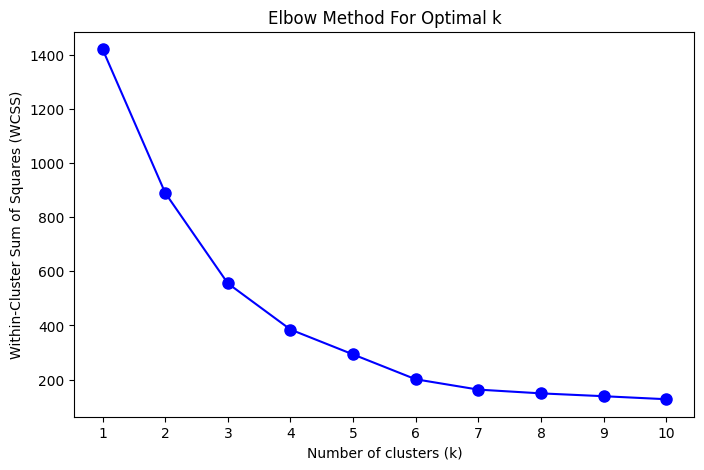

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.xticks(k_values)
plt.show()

In [12]:
kmeans_first_model = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_first_model.fit(X_scaled)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [13]:
from sklearn.metrics import silhouette_score

labels = kmeans_first_model.labels_
score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score for k=4: {score:.2f}")

Silhouette Score for k=4: 0.43


In [14]:
cluster_counts = pd.Series(labels).value_counts().sort_index()
print(cluster_counts)

0    145
1    119
2      1
3     69
Name: count, dtype: int64


> Given that one of the clusters (Cluster 2) contains only a single data point, this suggests potential overfitting or the presence of an outlier. Therefore, it may be more appropriate to reduce the number of clusters to k = 3, where the distribution of data points across clusters is more balanced and meaningful.

In [15]:
kmeans_second_model = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_second_model.fit(X_scaled)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [16]:
labels = kmeans_second_model.labels_
score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score for k=3: {score:.2f}")

Silhouette Score for k=3: 0.46


In [17]:
cluster_counts = pd.Series(labels).value_counts().sort_index()
print(cluster_counts)

0    213
1    120
2      1
Name: count, dtype: int64


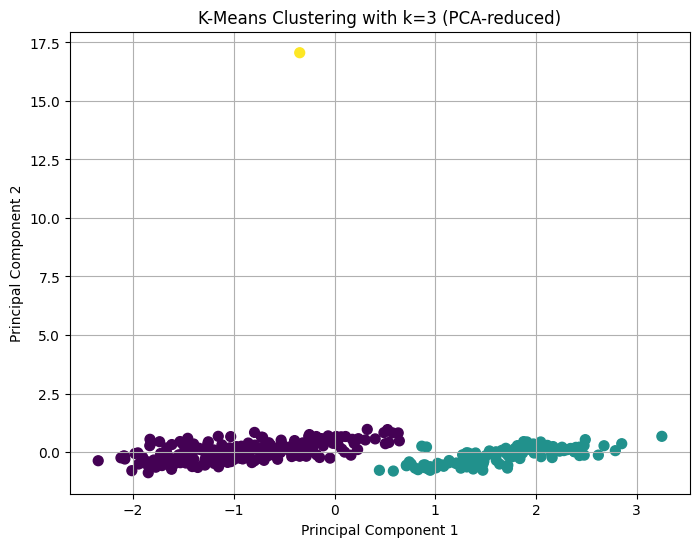

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_second_model.labels_, cmap='viridis', s=50)
plt.title("K-Means Clustering with k=3 (PCA-reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

> The Silhouette Score for k=3 is **0.461**, which, while not particularly high, still indicates a meaningful separation between clusters. Visually, the clusters appear to be reasonably well-formed and coherent, suggesting that the grouping makes intuitive sense based on the PCA-reduced representation. However, the presence of a very small cluster (with only one data point) still raises concerns about overfitting or noise. This supports the consideration of reducing **k** to 2 for a more robust and interpretable clustering outcome.

In [19]:
kmeans_third_model = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_third_model.fit(X_scaled)

KMeans(n_clusters=2, n_init=10, random_state=42)

In [20]:
labels = kmeans_third_model.labels_
score = silhouette_score(X_scaled, labels)
print(f"Silhouette Score for k=2: {score:.2f}")

Silhouette Score for k=2: 0.45


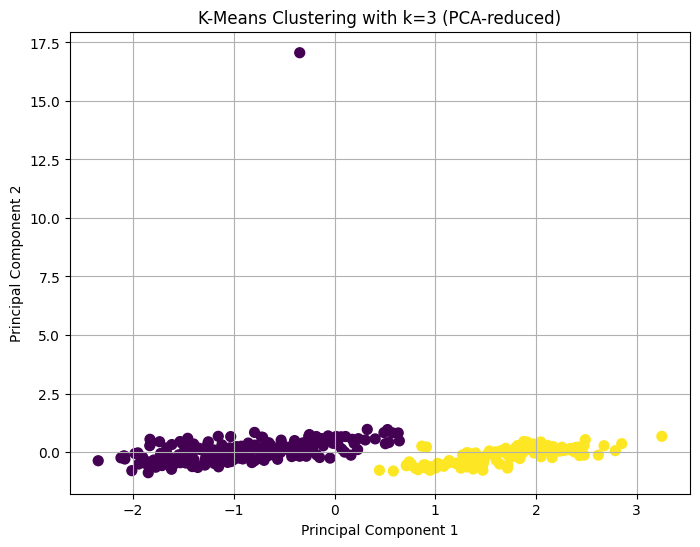

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_third_model.labels_, cmap='viridis', s=50)
plt.title("K-Means Clustering with k=3 (PCA-reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

The Silhouette Score for **k=2** is **0.450**, which is very close to the score for **k=3** (**0.461**). This suggests that both clustering solutions provide a similar level of separation between groups. However, when examining the PCA plot for **k=3**, one cluster (Cluster 2) contains only a single data point, which is visually apparent as a distant purple point separated from the main cluster structure. This likely represents an outlier rather than a meaningful group.

In contrast, the **k=2** configuration avoids assigning a separate cluster to this outlier and instead produces a more balanced and interpretable division of the data. While the Silhouette Score is slightly lower, the trade-off in interpretability and reduced sensitivity to noise makes **k=2** the more appropriate choice.

# DBSCAN Model 

In [22]:
from sklearn.cluster import DBSCAN

eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = range(3, 10)

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        # Count clusters (excluding noise label -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = np.sum(labels == -1)
        
        # Silhouette score: only if at least 2 clusters (excluding noise)
        if n_clusters > 1:
            sil_score = silhouette_score(X_scaled[labels != -1], labels[labels != -1])
        else:
            sil_score = -1  # Invalid score
        
        results.append((eps, min_samples, n_clusters, n_noise, sil_score))

        print(f"eps={eps:.2f}, min_samples={min_samples}, clusters={n_clusters}, noise={n_noise}, silhouette={sil_score:.3f}")


eps=0.10, min_samples=3, clusters=2, noise=328, silhouette=0.972
eps=0.10, min_samples=4, clusters=0, noise=334, silhouette=-1.000
eps=0.10, min_samples=5, clusters=0, noise=334, silhouette=-1.000
eps=0.10, min_samples=6, clusters=0, noise=334, silhouette=-1.000
eps=0.10, min_samples=7, clusters=0, noise=334, silhouette=-1.000
eps=0.10, min_samples=8, clusters=0, noise=334, silhouette=-1.000
eps=0.10, min_samples=9, clusters=0, noise=334, silhouette=-1.000
eps=0.20, min_samples=3, clusters=18, noise=243, silhouette=0.522
eps=0.20, min_samples=4, clusters=15, noise=257, silhouette=0.553
eps=0.20, min_samples=5, clusters=3, noise=314, silhouette=0.889
eps=0.20, min_samples=6, clusters=1, noise=327, silhouette=-1.000
eps=0.20, min_samples=7, clusters=1, noise=327, silhouette=-1.000
eps=0.20, min_samples=8, clusters=0, noise=334, silhouette=-1.000
eps=0.20, min_samples=9, clusters=0, noise=334, silhouette=-1.000
eps=0.30, min_samples=3, clusters=19, noise=110, silhouette=0.269
eps=0.30, mi

In [ ]:
dbsca_model_first = DBSCAN(eps=0.5, min_samples=9)
labels = dbsca_model_first.fit_predict(X_scaled)

> DBSCAN with eps=0.50 and min_samples=9 was selected as it produced 6 well-separated clusters with a Silhouette Score of 0.534 and only 54 noise points, offering a strong balance between cluster quality and data retention. Unlike higher-scoring configurations that labeled most data as noise, this setup preserves interpretability while effectively handling outliers. Compared to K-Means, where k=2 was preferred due to an isolated outlier in k=3, DBSCAN naturally excludes such anomalies without distorting the clustering structure, making it a more robust choice for this dataset.

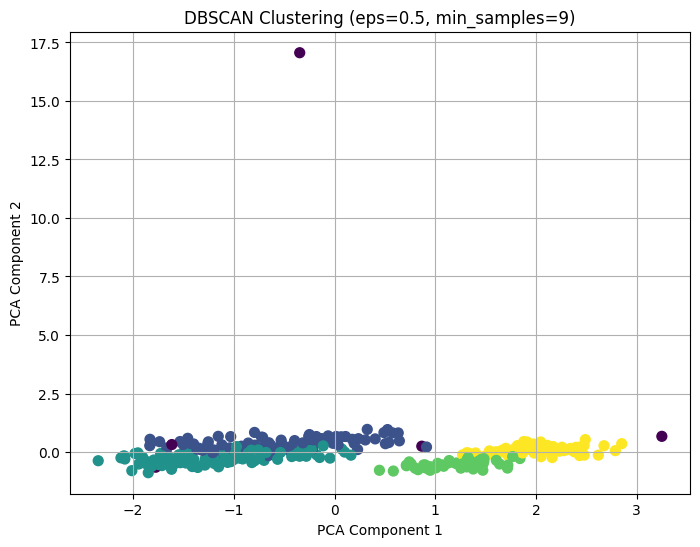

In [23]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.title('DBSCAN Clustering (eps=0.5, min_samples=9)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

> This model produced distinct clusters while effectively isolating noise, offering a more accurate representation of the underlying data structure. In contrast, K-Means forcibly assigned all points to clusters, including a clear outlier that distorted the clustering result. The PCA-reduced visualization shows that this model preserves dense regions without being influenced by anomalies, whereas K-Means placed the outlier into its own cluster, reducing interpretability.

In [27]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Filter out noise points (label = -1) because some metrics can't handle them
mask = labels != -1
X_clustered = X_scaled[mask]
labels_clustered = labels[mask]

sil_score = silhouette_score(X_clustered, labels_clustered)
db_index = davies_bouldin_score(X_clustered, labels_clustered)
ch_index = calinski_harabasz_score(X_clustered, labels_clustered)

print(f"Silhouette Score: {sil_score:.2f}")
print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Calinski-Harabasz Index: {ch_index:.2f}")

Silhouette Score: 0.40
Davies-Bouldin Index: 0.96
Calinski-Harabasz Index: 265.87


> This model produced moderately well-separated clusters, as indicated by a Silhouette Score of 0.40. The Davies-Bouldin Index of 0.96 reflects compact, distinct groupings, while the Calinski-Harabasz Index of 265.87 suggests a well-defined overall structure in the data.